# Introduction: the BSM model

#### Roland Grinis  -  Researcher at MIPT Nuclear Physics Methods lab  -  CTO at GrinisRIT (grinisrit.com)

In [1]:
import torch
import matplotlib.pyplot as plt
%matplotlib inline

If you like dark plots:

In [2]:
import seaborn as sns
sns.set_style('darkgrid',
                {'axes.facecolor': '.2',
                'figure.facecolor': '0.1',
                'text.color': '.9',
                'grid.color': '.5',
                'xtick.color': '.9',
                'ytick.color': '.9'})

## Introduction

### What are *derivatives*?

Assets include bonds, stocks, commodities, FX rates, cryptocurrencies etc. 

Examples: 

* Zero-coupon bond: a contract worth $P(t,T)$ at time $t$ that pays $P(T,T) = 1$ at maturity $t=T$

In [3]:
N = 365 # Actual/365 day counting convention
t = torch.linspace(0,1,N) # in years, maturity T = 1
time_to_maturity = 1 - t

Continuously-compounded spot interest rate 
$$
r(t,T) = - \frac{\ln P(t,T)}{T-t}
$$

In [49]:
spot_interest_rate = 0.01 * torch.rand(N) + 0.05 * torch.sigmoid(100 * (t-0.5))
bond = torch.exp(- time_to_maturity * spot_interest_rate)

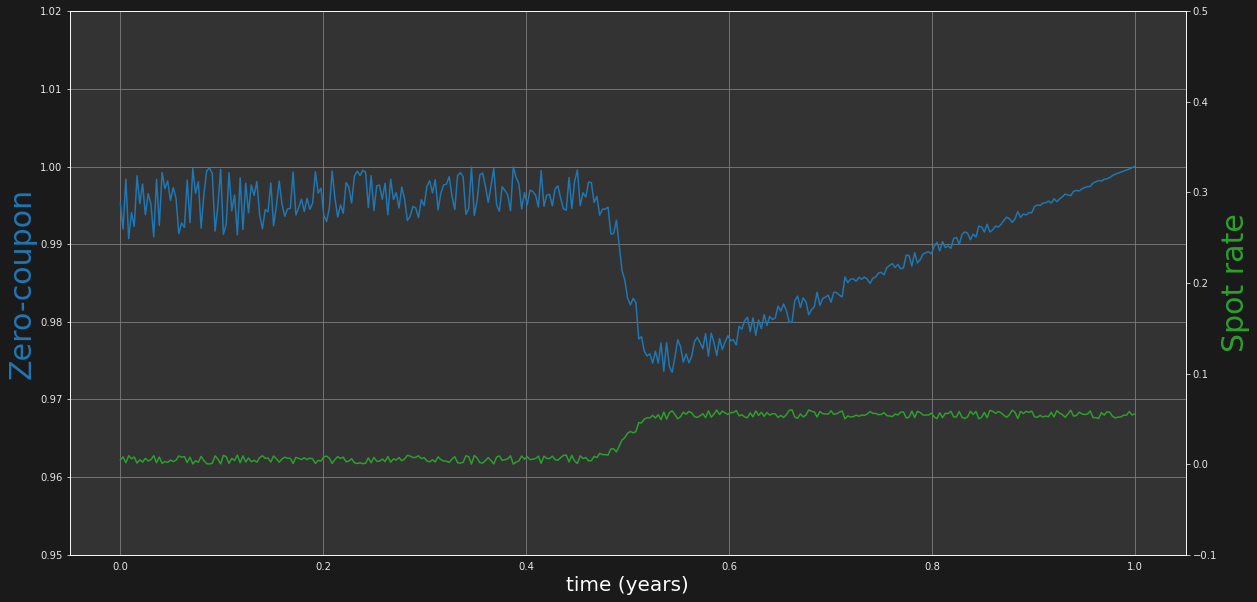

In [53]:
fig, ax1 = plt.subplots(figsize=(20,10))
ax1.set_xlabel('time (years)', color='white', fontsize=20)
ax1.set_ylabel('Zero-coupon', color='C0', fontsize=30)
ax1.plot(t.numpy(), bond.numpy(), 'C0')
ax1.set_ylim([0.95,1.02])

ax2 = ax1.twinx() 
ax2.grid(False)
ax2.set_ylabel('Spot rate', color='C2', fontsize=30)
ax2.plot(t.numpy(),spot_interest_rate.numpy(),color='C2')
ax2.set_ylim([-0.1,0.5])

plt.show()

A financial derivative is a contract between a Party (P) and its Counter-Party (CP) entered at time $t=t_0$ and settleted:
* at maturity $t=T$ (European style)
* at any time $t \leq T$ (American style)
* at some specified dates $t_1, t_2, \dots, T$ (Bermudan style)

according to a *payoff* function that depends on one or several securities (assets, or other derivatives).


### Who are *quants*?

Front office: 
* quant traders
* strategist (strats)
* quant modellers 
* quant developers

Back office:
* risk management
* regulatory 

## References

* Seydel, R.U. *Tools for Computational Finance*, 6th edition, Springer V., London (2017)
* Shreve, S.E. Stochastic Calculus for Finance I & II, Springer, New York (2004)
* Grzelak, L.A. et al. *Mathematical Modeling and Computation in Finance: With Exercises and Python and MATLAB Computer Codes*, World Scientific Pub. (2019)